In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In this notebook you can see the realisations of the baseline and the modified algorithm outlined in the referenced [paper](https://www.sciencedirect.com/science/article/pii/S0743731521001325)

## Baseline Algorithm

In [26]:
class Machine_basic:
    def __init__(self, default_speed, speed_time_delta):
        self.ds = default_speed - .3 #typically the speeds presented are lower than the real ones during overclocking
        self.std = speed_time_delta
        self.wh = [self.ds] #work history
        self.flg_work = False 

    def work(self, load_size):
        try:
            self.wh.append(max(self.wh[-1] + np.random.uniform(-self.std, self.std), 1e-3))
            return self.wh[-1]
        except:
            self.wh.append(1)
            return self.wh[-1]

    def check_work_finish(self):
        if self.flg_work:
            return False
        else:
            return self.wh[-1]

In [27]:
def sigmoid_basic(N_WG, N, S, kernel_type='reg'):
    
    def package_size(j, x, k, N_WG, S_i, S_T):
        return (1 - np.exp(-k*6*x/N_WG))*N_WG*S_i / ( (1 + np.exp(-k*6*x/N_WG)) * 2*N * S_T)

    p = .05
    x = N_WG
    time_arr, c_arr = [], []
    if kernel_type == 'reg':
        k = 2 #k for regular kernels
    else:
        k = .5 #k for irregular kernels

    oc, S_hist = [], np.zeros((N, 3))
    for j in range(N):
        oc.append(S[j].ds)
        c_arr.append(min(np.floor(package_size(j, x, k, N_WG, S[j].ds, max(oc))), x))
        S_hist[j, :] = S[j].work(c_arr[-1])
        time_arr.append(c_arr[-1] / S_hist[j, 0])
        x -= c_arr[-1] 
    oc, time_arr, c_arr = np.array(oc), np.array(time_arr), np.array(c_arr)
    time_delta = 0
    while x > 0:
        j_ = np.where(time_arr - time_delta == min(time_arr - time_delta))[0][0]
        speed = c_arr[j_] / time_arr[j_]
        S_hist[j_, :] = np.roll(S_hist[j_, :], 1)
        S_hist[j_, 0] = speed
        S_j = np.mean(S_hist[j_, :])
        std = np.std(S_hist[j_, :])
        if std / S_j > .25:
            k = .5 #situation consituting an irregular kernel
        c_arr[j_] = min(np.floor(max(package_size(j, x, k, N_WG, S_j, max(S_hist[:, 0])), .05*time_arr[j_]*S_hist[j_, 0], oc[j_])), x)
        time_delta = time_arr[j_]
        time_arr[j_] = c_arr[j_] / S[j_].work(c_arr[-1])
        x -= c_arr[-1]
    return S_hist[:, 0]

In [28]:
S = np.array([Machine_basic(5, .05), Machine_basic(3, .2), Machine_basic(6, .1)])
N_WG = 10_000
N = len(S)

sigmoid_basic(N_WG, N, S)

array([4.68048038, 2.57711854, 5.61380534])

## Modified Algorithm

Possible idea for improvement revolve around taking a larger sample to estimate the computing speed of the device. \
The idea is to increase the sample size and vary it based on the deviation induced by the last element. High deviation would suggest a saddle point in\
the function that describes the computing speed as a function of the load given, meaning that previous samples lose significantly in representativity

In [29]:
def sigmoid_v2(N_WG, N, S, kernel_type='reg'):
    
    def package_size(j, x, k, N_WG, S_i, S_T):
        return (1 - np.exp(-k*6*x/N_WG))*N_WG*S_i / ( (1 + np.exp(-k*6*x/N_WG)) * 2*N * S_T)

    p = .05
    x = N_WG
    time_arr, c_arr = [], []
    if kernel_type == 'reg':
        k = 2 #k for regular kernels
    else:
        k = .5 #k for irregular kernels

    oc, S_hist = [], np.zeros((N, 5))
    for j in range(N):
        oc.append(S[j].ds)
        c_arr.append(min(np.floor(package_size(j, x, k, N_WG, S[j].ds, max(oc))), x))
        S_hist[j, :] = S[j].work(c_arr[-1])
        time_arr.append(c_arr[-1] / S_hist[j, 0])
        x -= c_arr[-1] 
    oc, time_arr, c_arr = np.array(oc), np.array(time_arr), np.array(c_arr)
    time_delta, n, sample_size = 0, 0, 5
    std_last = 100
    while x > 0:
        j_ = np.where(time_arr - time_delta == min(time_arr - time_delta))[0][0]
        speed = c_arr[j_] / time_arr[j_]
        S_hist[j_, :sample_size] = np.roll(S_hist[j_, :sample_size], 1)
        S_hist[j_, 0] = speed
        std = np.std(S_hist[j_, :sample_size])
        if std > std_last*1.4:
            sample_size = 3
            n = 7
        elif n == 0:
            sample_size = 5
        S_j = np.mean(S_hist[j_, :sample_size])
        if std / S_j > .25:
            k = .5 #situation consituting an irregular kernel
        c_arr[j_] = min(np.floor(max(package_size(j, x, k, N_WG, S_j, max(S_hist[:, 0])), .05*time_arr[j_]*S_hist[j_, 0], oc[j_])), x)
        time_delta = time_arr[j_]
        time_arr[j_] = c_arr[j_] / S[j_].work(c_arr[-1])
        x -= c_arr[-1]
        std_last = std
        if n > 0:
            n -= 1
    return S_hist[:, 0]

In [30]:
S = np.array([Machine_basic(5, .05), Machine_basic(3, .2), Machine_basic(6, .1)])
N_WG = 20_000
N = len(S)

sigmoid_v2(N_WG, N, S)

array([4.72793454, 2.58746963, 5.6113304 ])

## Error comparison

Let us compare the precision of the two algorithms

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 277.01it/s]


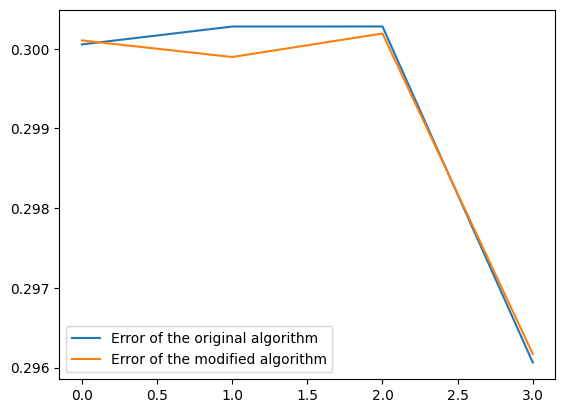

<Figure size 640x480 with 0 Axes>

In [33]:
sig_basic_hist, sig_v2_hist = [], []

N_WG = 30_000
N = 4

for i in tqdm(range(10_000)):
    S = np.array([Machine_basic(5, .05), Machine_basic(3, .02), Machine_basic(6, .01), Machine_basic(2.5, .017)])
    sig_basic_hist.append(sigmoid_basic(N_WG, N, S))
    S = np.array([Machine_basic(5, .05), Machine_basic(3, .02), Machine_basic(6, .01), Machine_basic(2.5, .017)])
    sig_v2_hist.append(sigmoid_v2(N_WG, N, S))

sig_basic_hist, sig_v2_hist = np.array(sig_basic_hist), np.array(sig_v2_hist)
plt.plot(np.abs(np.mean(sig_basic_hist, axis=0) - [5, 3, 6, 2.5]), label='Error of the original algorithm')
plt.plot(np.abs(np.mean(sig_v2_hist, axis=0) - [5, 3, 6, 2.5]), label='Error of the modified algorithm')
plt.legend()
plt.show()
plt.clf()

As we can see, the modified algorithm generally provides a smaller/ almost identical error in the estimation of the true computing speed of the device 